# DrugMechDB BiothingsExplorer TRAPI Analysis

This will be similar to `2_dmdb_mrn_analysis` but using the results we got from BTE Explorer.

This notebook is still under construction.

In [1]:
import pandas as pd
import networkx as nx
from pathlib import Path

import requests
from itertools import chain
from collections import defaultdict

from biothings_client import get_client

In [2]:
this_name = '4_dmdb_bte_trapi_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(exist_ok=True, parents=True)

data_dir = Path('../0_data/external').resolve()

In [3]:
ind = nx.read_yaml(data_dir.joinpath('indication_paths.yaml'))

In [4]:
prev_dir = Path('../2_pipeline/3_querying_bte_trapi/out/').resolve()
prev_result = pd.read_csv(prev_dir.joinpath('BTE_TRAPI_result.csv'))

## Drug info

In [3]:
dmdb_drugs = defaultdict(list)
for p in ind:
    for k in ['drug_mesh', 'drugbank', 'drug']:
        dmdb_drugs[k].append(p['graph'][k])
dmdb_drugs = pd.DataFrame(dmdb_drugs)

In [4]:
dmdb_drugs = dmdb_drugs.drop_duplicates().reset_index(drop=True)
dmdb_drugs

,drug_mesh,drugbank,drug
0,MESH:D000068877,DB:DB00619,imatinib
1,MESH:D000082,DB:DB00316,acetaminophen
2,MESH:D001241,DB:DB00945,acetylsalicylic acid
3,MESH:D009288,DB:DB00788,naproxen
4,MESH:D009643,DB:DB01059,norfloxacin
...,...,...,...
799,MESH:D003091,DB:DB00803,colistin
800,MESH:D000198,DB:DB00919,spectinomycin
801,"MESH:D008653,MESH:C529599",DB:DB00933,Mesoridazine
802,MESH:C025698,DB:DB00971,Selenium sulfide


## Nodes

In [5]:
dmdb_nodes = defaultdict(list)
for p in ind:
    for n in p['nodes']:
        for k in ['id', 'name', 'label']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_nodes[k].append(n[k].replace('\ufeff', ''))
dmdb_nodes = pd.DataFrame(dmdb_nodes)

## Edges

In [6]:
dmdb_edges = defaultdict(list)
for p in ind:
    for i, e in enumerate(p['links']):
        for k in ['source', 'key', 'target']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_edges[k].append(e[k].replace('\ufeff', ''))
        dmdb_edges['edge_num'].append(i+1)
        
dmdb_edges = pd.DataFrame(dmdb_edges)

In [7]:
dmdb_edges = (dmdb_edges.sort_values('edge_num')
                        .drop_duplicates(subset=['source', 'key', 'target'], keep='first')
                        .sort_values(['key', 'source', 'target'])
                        .reset_index(drop=True))
dmdb_edges

,source,key,target,edge_num
0,GO:0001508,actively involved in,MESH:D001007,6
1,GO:0001508,actively involved in,MESH:D016584,6
2,GO:0050806,actively involved in,GO:1904058,5
3,MESH:D003065,actively involved in,REACT:R-HSA-392499,3
4,CL:0002559,affected by,MESH:D000505,8
...,...,...,...,...
6000,UniProt:P35367,treats,MESH:D006255,2
6001,UniProt:P35367,treats,MESH:D011537,2
6002,UniProt:P35367,treats,MESH:D012223,2
6003,UniProt:P35367,treats,MESH:D014581,2


In [8]:
dmdb_edges.query('edge_num == 1')['key'].value_counts()

decreases activity of                417
increases activity of                159
negatively regulates                 156
positively regulates                  76
treats                                31
increases abundance of                30
molecularly interacts with            19
produces                              18
decreases abundance of                16
disrupts                              14
positively correlated with             6
subclass of                            6
has metabolite                         5
regulates                              4
capable of                             4
causes                                 4
chemically similar to                  4
derives into                           4
negatively correlated with             3
increases degradation of               3
part of                                3
decreases uptake of                    3
participates in                        2
prevents                               2
increases stabil

In [10]:
dmdb_nodes.query('label == "Protein"')

,id,name,label
1,UniProt:P00519,BCR/ABL,Protein
4,UniProt:P10721,c-Kit,Protein
5,UniProt:P16234,Pdgf,Protein
9,UniProt:P23219,Cox-1,Protein
10,UniProt:P35354,Cox-2,Protein
...,...,...,...
12084,UniProt:P28223,5-hydroxytryptamine receptor 2A,Protein
12085,UniProt:P08908,5-hydroxytryptamine receptor 1A,Protein
12093,UniProt:P14416,D(2) dopamine receptor,Protein
12094,UniProt:P28223,5-hydroxytryptamine receptor 2A,Protein


In [7]:
mg = get_client('gene')
mc = get_client('chem')

In [8]:
def uniprot_to_ncbi(uid):
    qid = uid.split(':')[-1]
    
    res = mg.query('uniprot:{}'.format(qid))
    if len(res.get('hits', [])) == 0:
        return None
    elif len(res.get('hits', [])) == 1:
        return 'NCBIGENE:{}'.format(res['hits'][0]['entrezgene'])
    else:
        return ['NCBIGENE:{}'.format(r['entrezgene']) for r in res['hits']]

In [9]:
uniprot_to_ncbi('UniProt:P10721')

'NCBIGENE:3815'

In [10]:
uniprot_to_ncbi('UniProt:P24941')

'NCBIGENE:1017'

In [15]:
query_prots = dmdb_nodes[dmdb_nodes['id'].str.startswith('UniProt:')]['id'].unique().tolist()
qr = mg.querymany([p.split(':')[-1] for p in query_prots], scopes='uniprot')

querying 1-518...done.
Finished.
5 input query terms found dup hits:
	[('P0A7S3', 2), ('P0A0H0', 2), ('P0DP23', 3), ('B4DP61', 2), ('P9WGR1', 2)]
72 input query terms found no hit:
	['P43702', 'P0C1U9', 'P20831', 'O05131', 'P44350', 'P72525', 'P44469', 'P08546', 'P0A0Z5', 'P0A3M6',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [16]:
uniprot_to_entrez = defaultdict(list)

for r in qr:
    uniprot_to_entrez['uniprot'].append('UniProt:'+r['query'])
    try:
        uniprot_to_entrez['entrez'].append('NCBIGENE:'+r['entrezgene'])
    except KeyError:
        uniprot_to_entrez['entrez'].append(float('nan'))
uniprot_to_entrez = pd.DataFrame(uniprot_to_entrez)

In [17]:
uniprot_to_entrez.head(10)

,uniprot,entrez
0,UniProt:P00519,NCBIGENE:25
1,UniProt:P10721,NCBIGENE:3815
2,UniProt:P16234,NCBIGENE:5156
3,UniProt:P23219,NCBIGENE:5742
4,UniProt:P35354,NCBIGENE:5743
5,UniProt:P43702,NaN
6,UniProt:P04150,NCBIGENE:2908
7,UniProt:P04083,NCBIGENE:301
8,UniProt:P0A7S3,NCBIGENE:53886437
9,UniProt:P0A7S3,NCBIGENE:947845


In [18]:
dmdb_nodes['id'].apply(lambda s: s.split(':')[0]).value_counts()

MESH         4583
GO           3211
UniProt      2263
NCBITaxon     428
HP            425
InterPro      289
UBERON        282
REACT         218
CHEBI         161
DB            104
CL             99
Pfam           23
PR             13
TIGR            3
Name: id, dtype: int64

In [73]:
d = {
    "message": {
        "query_graph": {
            "nodes": {
                "n0": {
                    "category": "biolink:Gene",
                    "id": []
                },
                "n1": {
                    "category": "biolink:ChemicalSubstance"
                }
            },
            "edges": {
                "e01": {
                    "subject": "n0",
                    "object": "n1"
                }
            }
        }
    }
}

def chunk_list(list_data, chunk_size):
    for i in range(0, len(list_data), chunk_size): 
        yield list_data[i:i + chunk_size]

In [20]:
def process_bte_result(result):
    out = defaultdict(list)
    for res in result.json()['message']['results']:
        out['n0'].append(res['node_bindings']['n0'][0]['id'])
        out['e01'].append(res['edge_bindings']['e01'][0]['id'].split('-')[1])
        out['n1'].append(res['node_bindings']['n1'][0]['id'])
    return pd.DataFrame(out)

In [67]:
URL = "https://api.bte.ncats.io/v1/query"

## Confirm that Batch yields same result as individual

In [22]:
%%time
n = next(chunk_list(uniprot_to_entrez['entrez'].dropna().unique().tolist(), chunk_size=10))
d['message']['query_graph']['nodes']['n0']['id'] = n
r = requests.post(URL, json=d)
batch = process_bte_result(r)

CPU times: user 52.9 ms, sys: 3.92 ms, total: 56.8 ms
Wall time: 6.73 s


In [49]:
import time

In [74]:
%%time
individual = []
for i, n in enumerate(next(chunk_list(uniprot_to_entrez['entrez'].dropna().unique().tolist(), chunk_size=10))):
    d['message']['query_graph']['nodes']['n0']['id'] = n
    r = requests.post(URL, json=d)
    individual.append(process_bte_result(r))
    ## New rate-limiting step on production makes this comparison more challenging...
    if i % 3 == 0:
        time.sleep(60)
individual = pd.concat(individual, ignore_index=True)

CPU times: user 285 ms, sys: 4.24 ms, total: 289 ms
Wall time: 4min 39s


In [93]:
from data_tools.plotting import venn2_pretty
import matplotlib.pyplot as plt

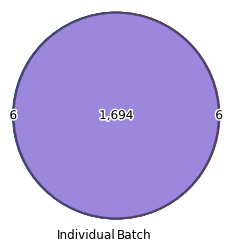

In [75]:
venn2_pretty([set(individual.apply(tuple, axis=1)), set(batch.apply(tuple, axis=1))], ('Individual', 'Batch'))

## Confirm Local query produces same result as Production

In [76]:
URL = "http://localhost:3000/v1/query"

In [77]:
%%time
n = next(chunk_list(uniprot_to_entrez['entrez'].dropna().unique().tolist(), chunk_size=10))
d['message']['query_graph']['nodes']['n0']['id'] = n
r = requests.post(URL, json=d)
batch_local = process_bte_result(r)

CPU times: user 46.9 ms, sys: 49 µs, total: 47 ms
Wall time: 7.21 s


In [95]:
%%time
individual_local = []
for n in next(chunk_list(uniprot_to_entrez['entrez'].dropna().unique().tolist(), chunk_size=10))[len(individual_local):]:
    d['message']['query_graph']['nodes']['n0']['id'] = n
    r = requests.post(URL, json=d)
    individual_local.append(process_bte_result(r))
individual_local = pd.concat(individual_local, ignore_index=True)

KeyError: 'message'

In [97]:
r

<Response [500]>

In [98]:
r.text

'{"error":"SyntaxError: Unexpected end of JSON input"}'

In [96]:
d

{'message': {'query_graph': {'nodes': {'n0': {'category': 'biolink:Gene',
     'id': 'NCBIGENE:25'},
    'n1': {'category': 'biolink:ChemicalSubstance'}},
   'edges': {'e01': {'subject': 'n0', 'object': 'n1'}}}}}

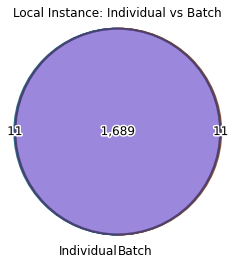

In [92]:
venn2_pretty([set(individual_local.apply(tuple, axis=1)), set(batch_local.apply(tuple, axis=1))], ('Individual', 'Batch'))
plt.title('Local Instance: Individual vs Batch');

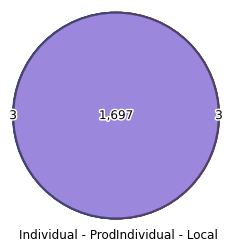

In [83]:
venn2_pretty([set(individual.apply(tuple, axis=1)), set(individual_local.apply(tuple, axis=1))], ('Individual - Prod', 'Individual - Local'))

In [84]:
len(individual.drop_duplicates()), len(individual_local.drop_duplicates())

(1700, 1700)

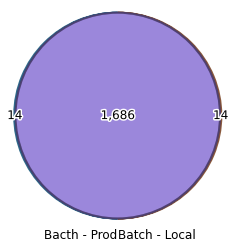

In [85]:
venn2_pretty([set(batch.apply(tuple, axis=1)), set(batch_local.apply(tuple, axis=1))], ('Bacth - Prod', 'Batch - Local'))

In [86]:
len(batch.drop_duplicates()), len(batch_local.drop_duplicates())

(1700, 1700)

### See if there are greater differences cross both variables

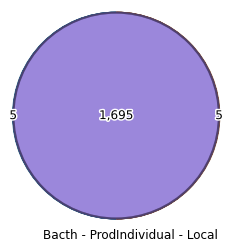

In [87]:
venn2_pretty([set(batch.apply(tuple, axis=1)), set(individual_local.apply(tuple, axis=1))], ('Bacth - Prod', 'Individual - Local'))

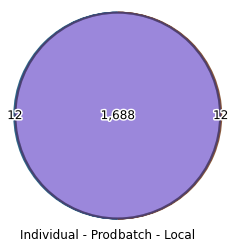

In [88]:
venn2_pretty([set(individual.apply(tuple, axis=1)), set(batch_local.apply(tuple, axis=1))], ('Individual - Prod', 'batch - Local'))

In [99]:
import json

In [105]:
import simplejson

In [106]:
simplejson.dumps(d)

'{"message": {"query_graph": {"nodes": {"n0": {"category": "biolink:Gene", "id": "NCBIGENE:25"}, "n1": {"category": "biolink:ChemicalSubstance"}}, "edges": {"e01": {"subject": "n0", "object": "n1"}}}}}'

In [116]:
d = {"message": {"query_graph": {"nodes": {"n0": {"category": "biolink:Gene",
     "id": "NCBIGENE:25"},
    "n1": {"category": "biolink:ChemicalSubstance"}},
   "edges": {"e01": {"subject": "n0", "object": "n1"}}}}}

URL = "http://localhost:3000/v1/query"

r = requests.post(URL, json=d)
r.text

'{"error":"SyntaxError: Unexpected end of JSON input"}'

In [111]:
print(d)

{'message': {'query_graph': {'nodes': {'n0': {'category': 'biolink:Gene', 'id': 'NCBIGENE:25'}, 'n1': {'category': 'biolink:ChemicalSubstance'}}, 'edges': {'e01': {'subject': 'n0', 'object': 'n1'}}}}}


In [110]:
d

{'message': {'query_graph': {'nodes': {'n0': {'category': 'biolink:Gene',
     'id': 'NCBIGENE:25'},
    'n1': {'category': 'biolink:ChemicalSubstance'}},
   'edges': {'e01': {'subject': 'n0', 'object': 'n1'}}}}}

In [53]:
URL = "https://api.bte.ncats.io/v1/query"
r = requests.post(URL, json=d)

In [26]:
results[0]

,n0,e01,n1
0,NCBIGENE:25,biolink:related_to,CHEBI:52172
1,NCBIGENE:25,biolink:related_to,CHEBI:45783
2,NCBIGENE:25,biolink:related_to,CHEBI:49375
3,NCBIGENE:25,biolink:related_to,CHEBI:68647
4,NCBIGENE:25,biolink:related_to,CHEBI:45783
...,...,...,...
3458,NCBIGENE:5743,biolink:entity_positively_regulates_entity,MESH:D012333
3459,NCBIGENE:5743,biolink:entity_positively_regulates_entity,MESH:D015054
3460,NCBIGENE:5743,biolink:entity_positively_regulates_entity,MESH:D017886
3461,NCBIGENE:5743,biolink:entity_positively_regulates_entity,DRUGBANK:DB08818


In [ ]:
results

In [65]:
result

{'node_bindings': {'n0': [{'id': 'NCBIGENE:1017'}],
  'n1': [{'id': 'CHEBI:85164'}]},
 'edge_bindings': {'e01': [{'id': 'NCBIGENE:1017-biolink:physically_interacts_with-CHEBI:85164'}]}}

In [46]:
r.json()['message']['results'][0]

{'node_bindings': {'n0': [{'id': 'NCBIGENE:25'}],
  'n1': [{'id': 'CHEBI:52172'}]},
 'edge_bindings': {'e01': [{'id': 'NCBIGENE:25-biolink:related_to-CHEBI:52172'}]}}

In [85]:
out = []
for result in r.json()['message']['results']:
    out.append(result['node_bindings']['n1'][0]['id'])

In [86]:
out

['CHEMBL.COMPOUND:CHEMBL4204794',
 'DRUGBANK:DB09103',
 'CHEBI:91433',
 'DRUGBANK:DB05146',
 'CHEBI:52172',
 'CHEBI:145373',
 'CHEBI:37788',
 'CHEBI:91389',
 'CHEMBL.COMPOUND:CHEMBL4216467',
 'DRUGBANK:DB06080',
 'CHEBI:63452',
 'CHEBI:38940',
 'CHEMBL.COMPOUND:CHEMBL3545376',
 'CHEBI:71219',
 'CHEBI:45783',
 'CHEBI:85994',
 'CHEBI:50924',
 'CHEBI:78543',
 'CHEBI:68647',
 'CHEBI:49375',
 'CHEMBL.COMPOUND:CHEMBL2103830',
 'CHEMBL.COMPOUND:CHEMBL3186534',
 'CHEBI:135147',
 'CHEBI:72317',
 'CHEBI:91327',
 'CHEBI:85994',
 'CHEBI:7553',
 'CHEBI:78543',
 'CHEBI:78432',
 'CHEBI:49668',
 'CHEBI:52172',
 'CHEBI:45783',
 'CHEBI:71219',
 'CHEBI:49375',
 'CHEBI:66910',
 'CHEMBL.COMPOUND:CHEMBL91829',
 'CHEBI:49960',
 'CHEBI:114785',
 'CHEBI:64310',
 'CHEBI:66919',
 'CHEBI:50924',
 'CHEBI:39112',
 'CHEBI:85164',
 'CHEBI:38940']